# This notebook handles ingestion of stocks data to feature store

In [11]:
import mlrun
project = mlrun.get_or_create_project(name='stocks',user_project=True, context="./")

> 2022-05-19 12:30:03,788 [info] loaded project stocks from MLRun DB


> <b> Steps </b>
> * [Creating mlrun function that reads stocks from yahoo_fin and returning record oriented json](#Creating-mlrun-function-that-reads-stocks-from-yahoo_fin-and-returning-record-oriented-json)
> * [Creating a feature set and declaring the graph](#Creating-a-feature-set-and-declaring-the-graph)
> * [Dummy ingestion, Deploying ingestion service and getting ingestion endpoint](#Dummy-ingestion,-Deploying-ingestion-service-and-getting-ingestion-endpoint)
> * [Testing ingestion service](#Testing-ingestion-service)
> * [Creating scheduled mlrun job to invoke our function every time delta](#Creating-scheduled-mlrun-job-to-invoke-our-function-every-time-delta)

## Creating mlrun function that reads stocks from yahoo_fin and returning record oriented json
similar to ingest_stocks, we collect the data from within the feature-set graph. <br>
event sent to graph is real-time configuration.

In [12]:
#mlrun: start-code

import yahoo_fin.stock_info as si
import yahoo_fin.news as ynews
from dateutil import parser
import pandas as pd 
import json
import requests
from storey import MapClass, Event
import string
import mlrun

def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

def get_news(event):
    '''
    event: dict with the following keys:
    n_stocks - how many stocks to collect
    '''
    tickers = si.tickers_sp500()[:event['n_stocks']]
    tickers_news = []
    for ticker in tickers:
        news = ynews.get_yf_rss(ticker=ticker)
        news_df = pd.DataFrame(news)
        df_copy = news_df[['title','summary','link','published']].copy()
        df_copy['ticker'] = ticker
        df_copy['Datetime'] = df_copy['published'].apply(lambda x: parser.parse(x).strftime('%Y-%m-%d %H:%M:%S'))
        df_copy['summary'] = df_copy['summary'].apply(lambda x:remove_punctuation(x))
        df_copy['title'] = df_copy['title'].apply(lambda x:remove_punctuation(x))
        tickers_news.append(df_copy)
    df = pd.concat(tickers_news).reset_index(drop=True)
    return json.loads(df.to_json(orient='records'))

class sentiment_analysis(MapClass):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        model_location = 'https://iguazio-sample-data.s3.amazonaws.com/models/model.pt'
        fn = mlrun.import_function('hub://sentiment_analysis_serving')
        fn.add_model('sentiment_analysis_model', model_path=model_location, class_name='SentimentClassifierServing')
        self.sentiment_model_endpoint = fn.deploy()
        
    def do(self,event):
        event.body['sentiment'] = json.loads(requests.put(self.sentiment_model_endpoint + "/v2/models/sentiment_analysis_model/predict",
                                                     json=json.dumps({'inputs':[event.body['summary']]})).text)['outputs'][0]/2 # so it'll be 0 for neg, 0.5 for neutral and 1 for pos
        
        return Event(event.body,key=event.body['ticker'],time=event.body['Datetime'])
    
#mlrun: end-code

## Creating a feature set and declaring the graph

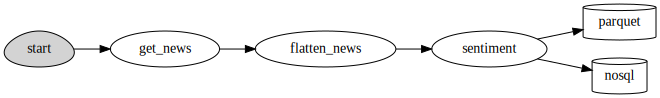

In [13]:
import mlrun.feature_store as fstore
from mlrun.feature_store.steps import DateExtractor, MapValues
import yahoo_fin.stock_info as si

# creating feature set
news_set = fstore.FeatureSet("stocks_news", 
                                 entities=[fstore.Entity("ticker")],
                                 timestamp_key='Datetime', 
                                 description="stocks news feature set")

# how many tickers data we ingest (make sure same number used for ingesting news)
# n_tickers = 4

news_set.graph\
    .to(name='get_news',handler='get_news')\
    .to("storey.steps.Flatten", name="flatten_news")\
    .to("sentiment_analysis", "sentiment",full_event=True)\

news_set.set_targets(with_defaults=True) 
news_set.plot(rankdir="LR", with_targets=True)

## Dummy ingestion, Deploying ingestion service and getting ingestion endpoint

In [14]:
# ingesting dummy (A MUST) 
import os
import datetime

name = os.environ['V3IO_USERNAME']
now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

fstore.ingest(news_set,
              pd.DataFrame.from_dict({'ticker':[name],
                                      'Datetime': now,
                                      'n_stocks':4}))

> 2022-05-19 12:30:04,217 [info] Starting remote function deploy
2022-05-19 12:30:04  (info) Deploying function
2022-05-19 12:30:04  (info) Building
2022-05-19 12:30:04  (info) Staging files and preparing base images
2022-05-19 12:30:04  (info) Building processor image
2022-05-19 12:31:49  (info) Build complete
2022-05-19 12:32:15  (info) Function deploy complete
> 2022-05-19 12:32:15,789 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-stocks-avia-sentiment-analysis-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['stocks-avia-sentiment-analysis-serving-stocks-avia.default-tenant.app.app-lab-eks-b71.iguazio-cd0.com/']}
> 2022-05-19 12:32:40,376 [info] Starting remote function deploy
2022-05-19 12:32:40  (info) Deploying function
2022-05-19 12:32:40  (info) Building
2022-05-19 12:32:40  (info) Staging files and preparing base images
2022-05-19 12:32:40  (info) Building processor image
2022-05-19 12:34:30  (info) Build complete
20

title  \
ticker                                                      
A       Agilent Announces Cash Dividend of 21 Cents pe...   
A       Agilent Technologies A Earnings Expected to Gr...   
A       Agilent Companion Diagnostic Expands CEIVD Mar...   
A           Ken Fisher is Selling These 10 Stocks in 2022   
A       Cognex Corporation CGNX Q1 Earnings and Revenu...   
...                                                   ...   
AAPL    Market selloff SP 500 has worst day since June...   
AAPL    10 years after Facebook’s recordbreaking IPO a...   
AAPL    Apple takes shots at Meta Google in new privac...   
AAPL    What to expect at the 2022 Davos World Economi...   
AAPL                     Why Apple Stock Is Falling Today   

                                                  summary  \
ticker                                                      
A       SANTA CLARA Calif May 18 2022Agilent Technolog...   
A       Agilent A doesnt possess the right combination...   
A       SANTA CLARA Calif May 10 2022Agilent Technolog...   
A       In this article we will discuss some stocks so...   
A       Cognex Corporation CGNX delivered earnings and...   
...                                                   ...   
AAPL    Stocks are trading at the lows of the session ...   
AAPL    After a recordbreaking initial public offering...   
AAPL    Apple is taking on the whole internet in its n...   
AAPL    Everything you need to know ahead of the 2022 ...   
AAPL    Shares of Apple NASDAQ AAPL were falling 39 he...   

                                                     link  \
ticker                                                      
A       https://finance.yahoo.com/news/agilent-announc...   
A       https://finance.yahoo.com/news/agilent-technol...   
A       https://finance.yahoo.com/news/agilent-compani...   
A       https://finance.yahoo.com/news/ken-fisher-sell...   
A       https://finance.yahoo.com/news/cognex-corporat...   
...                                                   ...   
AAPL    https://finance.yahoo.com/video/market-sell-of...   
AAPL    https://finance.yahoo.com/m/a6606990-3332-33eb...   
AAPL    https://finance.yahoo.com/news/apple-takes-sho...   
AAPL    https://finance.yahoo.com/video/expect-2022-da...   
AAPL    https://finance.yahoo.com/m/b753c0d1-b946-3058...   

                              published            Datetime  sentiment  
ticker                                                                  
A       Wed, 18 May 2022 20:05:00 +0000 2022-05-18 20:05:00        0.0  
A       Tue, 17 May 2022 19:00:07 +0000 2022-05-17 19:00:07        0.5  
A       Tue, 10 May 2022 19:50:00 +0000 2022-05-10 19:50:00        1.0  
A       Fri, 06 May 2022 20:55:50 +0000 2022-05-06 20:55:50        1.0  
A       Thu, 05 May 2022 22:05:10 +0000 2022-05-05 22:05:10        1.0  
...                                 ...                 ...        ...  
AAPL    Wed, 18 May 2022 19:55:10 +0000 2022-05-18 19:55:10        0.0  
AAPL    Wed, 18 May 2022 19:44:00 +0000 2022-05-18 19:44:00        0.0  
AAPL    Wed, 18 May 2022 18:20:03 +0000 2022-05-18 18:20:03        0.0  
AAPL    Wed, 18 May 2022 17:00:07 +0000 2022-05-18 17:00:07        1.0  
AAPL    Wed, 18 May 2022 16:31:06 +0000 2022-05-18 16:31:06        0.0  

[80 rows x 6 columns]

In [15]:
# Define the HTTP Source to_dictable the HTTP trigger on our function and expose the endpoint.
# There is an option to declare key and timestamp inside the http source (here we dont send data through the http hence not needed)
http_source = mlrun.datastore.sources.HttpSource()
news_set.spec.source = http_source

# code_to_function our mlrun wrapped function to deploy the ingestion pipeline on.
# the serving runtimes enables the deployment of our feature set's computational graph
function = mlrun.code_to_function(name='get_news',kind='serving',image='mlrun/mlrun', requirements=['yahoo_fin','graphviz'])
function.spec.readiness_timeout=100000

run_config = fstore.RunConfig(function=function, local=False).apply(mlrun.mount_v3io())

In [16]:
# Deploying
news_set_endpoint = fstore.deploy_ingestion_service(featureset=news_set, run_config=run_config)

> 2022-05-19 12:36:11,089 [info] Starting remote function deploy
2022-05-19 12:36:11  (info) Deploying function
2022-05-19 12:36:11  (info) Building
2022-05-19 12:36:11  (info) Staging files and preparing base images
2022-05-19 12:36:11  (info) Building processor image
2022-05-19 12:36:51  (info) Build complete
2022-05-19 12:40:01  (info) Function deploy complete
> 2022-05-19 12:40:02,237 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-stocks-avia-get-news.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['stocks-avia-get-news-stocks-avia.default-tenant.app.app-lab-eks-b71.iguazio-cd0.com/']}


## Testing ingestion service

In [17]:
import requests
import json

now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

t = requests.post(news_set_endpoint,json={'ticker':['news'],
                                                 'Datetime': now,
                                                 'n_stocks':4})
t.text

'{"id": "8d7ac435-79c1-4b85-837a-d5d5f9462b2c"}'

## Creating scheduled mlrun job to invoke our function every time delta

In [18]:
os.makedirs('src',exist_ok=True)

In [19]:
%%writefile src/invoker.py

import requests
import datetime

def ingestion_service_invoker(endpoint): 
    now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    t = requests.post(endpoint,json={'ticker':['news'],
                                     'Datetime': now,
                                     'n_stocks':4})

Overwriting src/invoker.py


In [20]:
# specifying '0 8 * * *' as schedule will trigger the function every day at 08:00 AM
fn = mlrun.code_to_function(name='ingestion_service_news',kind='job',image='mlrun/mlrun',handler='ingestion_service_invoker', filename='src/invoker.py')
fn.run(params={'endpoint':news_set_endpoint}, schedule='0 8 * * *')

> 2022-05-19 12:40:02,419 [info] starting run ingestion-service-news-ingestion_service_invoker uid=222f76a5063f41f8925678b272f84210 DB=http://mlrun-api:8080
> 2022-05-19 12:40:02,655 [info] task scheduled, {'schedule': '0 8 * * *', 'project': 'stocks-avia', 'name': 'ingestion-service-news-ingestion_service_invoker'}
